# FCM Combined Segment

Tumor centroid detected at (x=110.8, y=198.8)


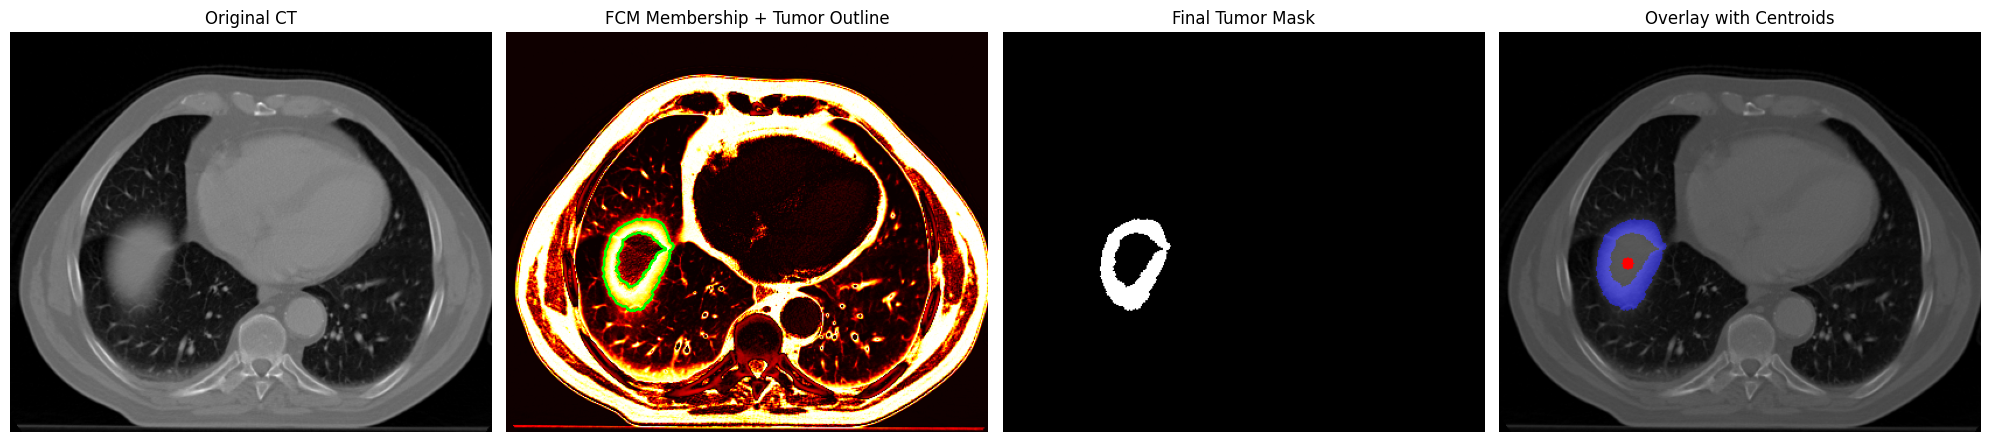

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes, disk, opening
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import skfuzzy as fuzz


class FCM_Combined_Segmenter:
    def __init__(
        self,
        image: np.ndarray,
        num_clusters: int = 3,
        m: float = 2.0,
        max_iter: int = 150,
        threshold: float = 1e-5,
        tumor_cluster: int | None = None,
        confine_to_lungs: bool = True,
        target_lobe: str = "none",      # default none → detect anywhere in lungs
        lobe_margin: float = 0.07,
        brightness_min: float = 0.35,
        min_area: int = 120,
        max_area_frac_of_lung: float = 0.35,
    ) -> None:
        self.image = image
        self.num_clusters = num_clusters
        self.m = m
        self.max_iter = max_iter
        self.threshold = threshold
        self.tumor_cluster = tumor_cluster
        self.confine_to_lungs = confine_to_lungs
        self.target_lobe = target_lobe
        self.lobe_margin = lobe_margin
        self.brightness_min = brightness_min
        self.min_area = min_area
        self.max_area_frac_of_lung = max_area_frac_of_lung

    def _normalize(self):
        img = self.image.astype(np.float32)
        mn, mx = float(img.min()), float(img.max())
        norm = (img - mn) / (mx - mn + 1e-8)
        flat = norm.reshape(-1, 1)
        return norm, flat

    def _lung_mask(self):
        _, thr = cv2.threshold(self.image, 100, 255, cv2.THRESH_BINARY_INV)
        mask = thr > 0
        mask = remove_small_objects(mask, min_size=1500)
        mask = remove_small_holes(mask, area_threshold=2000)
        return mask.astype(np.bool_)

    def _overlay_with_centroids(self, mask, centroids, color_mask=(255, 0, 0), color_dot=(0, 0, 255)):
        ct_rgb = cv2.cvtColor(self.image, cv2.COLOR_GRAY2BGR)

        # paint only accepted blobs
        tumor_layer = np.zeros_like(ct_rgb)
        tumor_layer[mask == 1] = color_mask
        overlay = cv2.addWeighted(ct_rgb, 0.7, tumor_layer, 0.5, 0)

        # add centroid markers
        for (cy, cx) in centroids:
            cv2.circle(overlay, (int(cx), int(cy)), 5, color_dot, -1)

        return overlay

    def _passes_morph_heuristics(self, prop):
        if prop.eccentricity > 0.95:
            return False
        if prop.solidity >= 0.99:
            return False
        return True

    def _passes_lobe_filter(self, centroid):
        if self.target_lobe == "none":
            return True
        h, w = self.image.shape[:2]
        cy, cx = centroid
        x_mid = w * 0.5
        y_mid = h * 0.5
        y_upper = y_mid * (1.0 - self.lobe_margin)
        y_lower = y_mid * (1.0 + self.lobe_margin)
        if self.target_lobe == "left_lower":
            return (cx < x_mid) and (cy > y_lower)
        if self.target_lobe == "left_upper":
            return (cx < x_mid) and (cy < y_upper)
        if self.target_lobe == "right_lower":
            return (cx >= x_mid) and (cy > y_lower)
        if self.target_lobe == "right_upper":
            return (cx >= x_mid) and (cy < y_upper)
        return True

    def segment(self):
        norm, flat = self._normalize()
        cntr, u, *_ = fuzz.cluster.cmeans(flat.T, self.num_clusters, self.m, error=self.threshold, maxiter=self.max_iter)
        lung = self._lung_mask()

        # auto-pick bright cluster inside lungs
        if self.tumor_cluster is None:
            centers = cntr.ravel()
            means_in_lung = [np.mean(u[i].reshape(self.image.shape)[lung]) for i in range(self.num_clusters)]
            scores = [float(centers[i]) * float(means_in_lung[i]) for i in range(self.num_clusters)]
            self.tumor_cluster = int(np.argmax(scores))

        membership_map = u[self.tumor_cluster].reshape(self.image.shape)
        t = threshold_otsu(membership_map)
        binary = (membership_map > t).astype(np.uint8)

        cleaned = remove_small_objects(binary.astype(bool), min_size=150)
        cleaned = remove_small_holes(cleaned, area_threshold=600)
        cleaned = opening(cleaned, disk(3))
        mask = cleaned.astype(np.uint8)

        if self.confine_to_lungs:
            mask = np.logical_and(mask, lung).astype(np.uint8)

        lbl = label(mask)
        out = np.zeros_like(mask)   # only accepted blobs here
        lung_area = int(lung.sum()) if lung.any() else mask.size
        max_area = int(self.max_area_frac_of_lung * lung_area)
        centroids = []

        for prop in regionprops(lbl):
            if not (self.min_area <= prop.area <= max_area):
                continue
            rr, cc = np.where(lbl == prop.label)
            mean_intensity = float(np.mean(norm[rr, cc]))
            if mean_intensity < self.brightness_min:
                continue
            if not self._passes_morph_heuristics(prop):
                continue
            if not self._passes_lobe_filter(prop.centroid):
                continue

            out[lbl == prop.label] = 1
            centroids.append(prop.centroid)

            print(f"Tumor centroid detected at (x={prop.centroid[1]:.1f}, y={prop.centroid[0]:.1f})")

        overlay = self._overlay_with_centroids(out, centroids)
        return self.image, membership_map, out, overlay


if __name__ == "__main__":
    img_path =  r"D:\FYP\DATASET\kagglehub\datasets\mohamedhanyyy\chest-ctscan-images\versions\1\Data\train\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000084 (7).png"
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    seg = FCM_Combined_Segmenter(
        img,
        num_clusters=3,
        tumor_cluster=None,
        confine_to_lungs=True,
        target_lobe="none",       # detect anywhere in lungs
        lobe_margin=0.07,
        brightness_min=0.35,
        min_area=120,
        max_area_frac_of_lung=0.35,
    )

    original, membership_map, final_mask, overlay = seg.segment()

    # --- Plotting with tumor outline on heatmap ---
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))
    axs[0].imshow(original, cmap="gray")
    axs[0].set_title("Original CT")

    axs[1].imshow(membership_map, cmap="hot")
    axs[1].contour(final_mask, colors="lime", linewidths=1)   # ✅ outline only accepted tumor
    axs[1].set_title("FCM Membership + Tumor Outline")

    axs[2].imshow(final_mask, cmap="gray")
    axs[2].set_title("Final Tumor Mask")

    axs[3].imshow(overlay[..., ::-1])
    axs[3].set_title("Overlay with Centroids")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


Tumor centroid detected at (x=83.9, y=143.8)


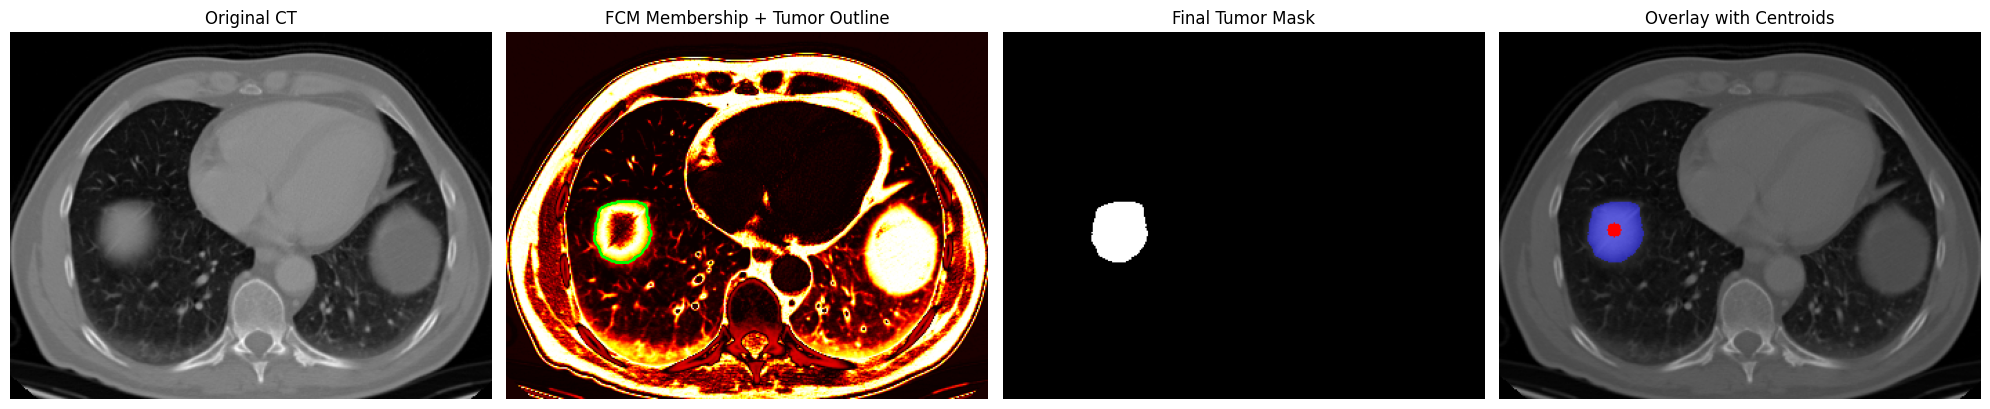

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes, disk, opening
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import skfuzzy as fuzz


class FCM_Combined_Segmenter:
    def __init__(
        self,
        image: np.ndarray,
        num_clusters: int = 3,
        m: float = 2.0,
        max_iter: int = 150,
        threshold: float = 1e-5,
        tumor_cluster: int | None = None,
        confine_to_lungs: bool = True,
        target_lobe: str = "none",      # default none → detect anywhere in lungs
        lobe_margin: float = 0.07,
        brightness_min: float = 0.35,
        min_area: int = 120,
        max_area_frac_of_lung: float = 0.35,
    ) -> None:
        self.image = image
        self.num_clusters = num_clusters
        self.m = m
        self.max_iter = max_iter
        self.threshold = threshold
        self.tumor_cluster = tumor_cluster
        self.confine_to_lungs = confine_to_lungs
        self.target_lobe = target_lobe
        self.lobe_margin = lobe_margin
        self.brightness_min = brightness_min
        self.min_area = min_area
        self.max_area_frac_of_lung = max_area_frac_of_lung

    def _normalize(self):
        img = self.image.astype(np.float32)
        mn, mx = float(img.min()), float(img.max())
        norm = (img - mn) / (mx - mn + 1e-8)
        flat = norm.reshape(-1, 1)
        return norm, flat

    def _lung_mask(self):
        _, thr = cv2.threshold(self.image, 100, 255, cv2.THRESH_BINARY_INV)
        mask = thr > 0
        mask = remove_small_objects(mask, min_size=1500)
        mask = remove_small_holes(mask, area_threshold=2000)
        return mask.astype(np.bool_)

    def _overlay_with_centroids(self, mask, centroids, color_mask=(255, 0, 0), color_dot=(0, 0, 255)):
        ct_rgb = cv2.cvtColor(self.image, cv2.COLOR_GRAY2BGR)

        # paint only accepted blobs
        tumor_layer = np.zeros_like(ct_rgb)
        tumor_layer[mask == 1] = color_mask
        overlay = cv2.addWeighted(ct_rgb, 0.7, tumor_layer, 0.5, 0)

        # add centroid markers
        for (cy, cx) in centroids:
            cv2.circle(overlay, (int(cx), int(cy)), 5, color_dot, -1)

        return overlay

    def _passes_morph_heuristics(self, prop):
        if prop.eccentricity > 0.95:
            return False
        if prop.solidity >= 0.99:
            return False
        return True

    def _passes_lobe_filter(self, centroid):
        if self.target_lobe == "none":
            return True
        h, w = self.image.shape[:2]
        cy, cx = centroid
        x_mid = w * 0.5
        y_mid = h * 0.5
        y_upper = y_mid * (1.0 - self.lobe_margin)
        y_lower = y_mid * (1.0 + self.lobe_margin)
        if self.target_lobe == "left_lower":
            return (cx < x_mid) and (cy > y_lower)
        if self.target_lobe == "left_upper":
            return (cx < x_mid) and (cy < y_upper)
        if self.target_lobe == "right_lower":
            return (cx >= x_mid) and (cy > y_lower)
        if self.target_lobe == "right_upper":
            return (cx >= x_mid) and (cy < y_upper)
        return True

    def segment(self):
        norm, flat = self._normalize()
        cntr, u, *_ = fuzz.cluster.cmeans(flat.T, self.num_clusters, self.m, error=self.threshold, maxiter=self.max_iter)
        lung = self._lung_mask()

        # auto-pick bright cluster inside lungs
        if self.tumor_cluster is None:
            centers = cntr.ravel()
            means_in_lung = [np.mean(u[i].reshape(self.image.shape)[lung]) for i in range(self.num_clusters)]
            scores = [float(centers[i]) * float(means_in_lung[i]) for i in range(self.num_clusters)]
            self.tumor_cluster = int(np.argmax(scores))

        membership_map = u[self.tumor_cluster].reshape(self.image.shape)
        t = threshold_otsu(membership_map)
        binary = (membership_map > t).astype(np.uint8)

        cleaned = remove_small_objects(binary.astype(bool), min_size=150)
        cleaned = remove_small_holes(cleaned, area_threshold=600)
        cleaned = opening(cleaned, disk(3))
        mask = cleaned.astype(np.uint8)

        if self.confine_to_lungs:
            mask = np.logical_and(mask, lung).astype(np.uint8)

        lbl = label(mask)
        out = np.zeros_like(mask)   # only accepted blobs here
        lung_area = int(lung.sum()) if lung.any() else mask.size
        max_area = int(self.max_area_frac_of_lung * lung_area)
        centroids = []

        for prop in regionprops(lbl):
            if not (self.min_area <= prop.area <= max_area):
                continue
            rr, cc = np.where(lbl == prop.label)
            mean_intensity = float(np.mean(norm[rr, cc]))
            if mean_intensity < self.brightness_min:
                continue
            if not self._passes_morph_heuristics(prop):
                continue
            if not self._passes_lobe_filter(prop.centroid):
                continue

            out[lbl == prop.label] = 1
            centroids.append(prop.centroid)

            print(f"Tumor centroid detected at (x={prop.centroid[1]:.1f}, y={prop.centroid[0]:.1f})")

        overlay = self._overlay_with_centroids(out, centroids)
        return self.image, membership_map, out, overlay


if __name__ == "__main__":
    img_path = r"D:\FYP\DATASET\kagglehub\datasets\mohamedhanyyy\chest-ctscan-images\versions\1\Data\train\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000083 (3).png"
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    seg = FCM_Combined_Segmenter(
        img,
        num_clusters=3,
        tumor_cluster=None,
        confine_to_lungs=True,
        target_lobe="none",       # detect anywhere in lungs
        lobe_margin=0.07,
        brightness_min=0.35,
        min_area=120,
        max_area_frac_of_lung=0.35,
    )

    original, membership_map, final_mask, overlay = seg.segment()

    # --- Plotting with tumor outline on heatmap ---
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))
    axs[0].imshow(original, cmap="gray")
    axs[0].set_title("Original CT")

    axs[1].imshow(membership_map, cmap="hot")
    axs[1].contour(final_mask, colors="lime", linewidths=1)   # ✅ outline only accepted tumor
    axs[1].set_title("FCM Membership + Tumor Outline")

    axs[2].imshow(final_mask, cmap="gray")
    axs[2].set_title("Final Tumor Mask")

    axs[3].imshow(overlay[..., ::-1])
    axs[3].set_title("Overlay with Centroids")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


Tumor centroid detected at (x=213.8, y=146.9)
Tumor centroid detected at (x=222.5, y=93.2)
Tumor centroid detected at (x=142.9, y=159.7)
Tumor centroid detected at (x=176.3, y=221.8)
Tumor centroid detected at (x=266.4, y=226.1)


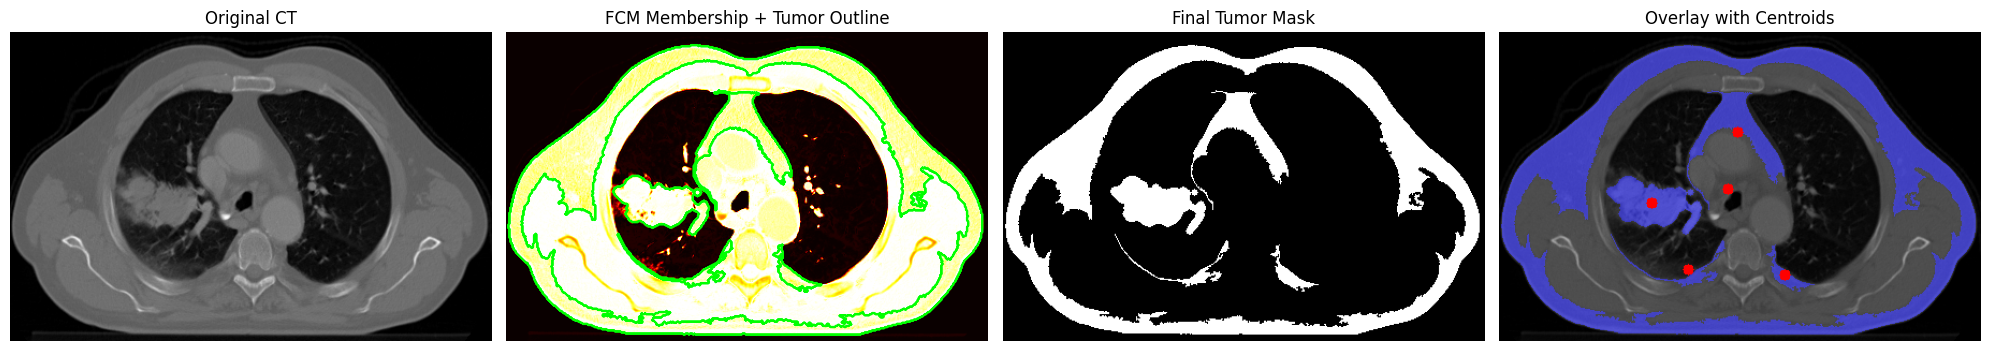

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes, disk, opening
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import skfuzzy as fuzz


class FCM_Combined_Segmenter:
    def __init__(
        self,
        image: np.ndarray,
        num_clusters: int = 3,
        m: float = 2.0,
        max_iter: int = 150,
        threshold: float = 1e-5,
        tumor_cluster: int | None = None,
        confine_to_lungs: bool = True,
        target_lobe: str = "none",      # default none → detect anywhere in lungs
        lobe_margin: float = 0.07,
        brightness_min: float = 0.35,
        min_area: int = 120,
        max_area_frac_of_lung: float = 0.35,
    ) -> None:
        self.image = image
        self.num_clusters = num_clusters
        self.m = m
        self.max_iter = max_iter
        self.threshold = threshold
        self.tumor_cluster = tumor_cluster
        self.confine_to_lungs = confine_to_lungs
        self.target_lobe = target_lobe
        self.lobe_margin = lobe_margin
        self.brightness_min = brightness_min
        self.min_area = min_area
        self.max_area_frac_of_lung = max_area_frac_of_lung

    def _normalize(self):
        img = self.image.astype(np.float32)
        mn, mx = float(img.min()), float(img.max())
        norm = (img - mn) / (mx - mn + 1e-8)
        flat = norm.reshape(-1, 1)
        return norm, flat

    def _lung_mask(self):
        _, thr = cv2.threshold(self.image, 100, 255, cv2.THRESH_BINARY_INV)
        mask = thr > 0
        mask = remove_small_objects(mask, min_size=1500)
        mask = remove_small_holes(mask, area_threshold=2000)
        return mask.astype(np.bool_)

    def _overlay_with_centroids(self, mask, centroids, color_mask=(255, 0, 0), color_dot=(0, 0, 255)):
        ct_rgb = cv2.cvtColor(self.image, cv2.COLOR_GRAY2BGR)

        # paint only accepted blobs
        tumor_layer = np.zeros_like(ct_rgb)
        tumor_layer[mask == 1] = color_mask
        overlay = cv2.addWeighted(ct_rgb, 0.7, tumor_layer, 0.5, 0)

        # add centroid markers
        for (cy, cx) in centroids:
            cv2.circle(overlay, (int(cx), int(cy)), 5, color_dot, -1)

        return overlay

    def _passes_morph_heuristics(self, prop):
        if prop.eccentricity > 0.95:
            return False
        if prop.solidity >= 0.99:
            return False
        return True

    def _passes_lobe_filter(self, centroid):
        if self.target_lobe == "none":
            return True
        h, w = self.image.shape[:2]
        cy, cx = centroid
        x_mid = w * 0.5
        y_mid = h * 0.5
        y_upper = y_mid * (1.0 - self.lobe_margin)
        y_lower = y_mid * (1.0 + self.lobe_margin)
        if self.target_lobe == "left_lower":
            return (cx < x_mid) and (cy > y_lower)
        if self.target_lobe == "left_upper":
            return (cx < x_mid) and (cy < y_upper)
        if self.target_lobe == "right_lower":
            return (cx >= x_mid) and (cy > y_lower)
        if self.target_lobe == "right_upper":
            return (cx >= x_mid) and (cy < y_upper)
        return True

    def segment(self):
        norm, flat = self._normalize()
        cntr, u, *_ = fuzz.cluster.cmeans(flat.T, self.num_clusters, self.m, error=self.threshold, maxiter=self.max_iter)
        lung = self._lung_mask()

        # auto-pick bright cluster inside lungs
        if self.tumor_cluster is None:
            centers = cntr.ravel()
            means_in_lung = [np.mean(u[i].reshape(self.image.shape)[lung]) for i in range(self.num_clusters)]
            scores = [float(centers[i]) * float(means_in_lung[i]) for i in range(self.num_clusters)]
            self.tumor_cluster = int(np.argmax(scores))

        membership_map = u[self.tumor_cluster].reshape(self.image.shape)
        t = threshold_otsu(membership_map)
        binary = (membership_map > t).astype(np.uint8)

        cleaned = remove_small_objects(binary.astype(bool), min_size=150)
        cleaned = remove_small_holes(cleaned, area_threshold=600)
        cleaned = opening(cleaned, disk(3))
        mask = cleaned.astype(np.uint8)

        if self.confine_to_lungs:
            mask = np.logical_and(mask, lung).astype(np.uint8)

        lbl = label(mask)
        out = np.zeros_like(mask)   # only accepted blobs here
        lung_area = int(lung.sum()) if lung.any() else mask.size
        max_area = int(self.max_area_frac_of_lung * lung_area)
        centroids = []

        for prop in regionprops(lbl):
            if not (self.min_area <= prop.area <= max_area):
                continue
            rr, cc = np.where(lbl == prop.label)
            mean_intensity = float(np.mean(norm[rr, cc]))
            if mean_intensity < self.brightness_min:
                continue
            if not self._passes_morph_heuristics(prop):
                continue
            if not self._passes_lobe_filter(prop.centroid):
                continue

            out[lbl == prop.label] = 1
            centroids.append(prop.centroid)

            print(f"Tumor centroid detected at (x={prop.centroid[1]:.1f}, y={prop.centroid[0]:.1f})")

        overlay = self._overlay_with_centroids(out, centroids)
        return self.image, membership_map, out, overlay


if __name__ == "__main__":
    img_path = r"D:\FYP\DATASET\kagglehub\datasets\mohamedhanyyy\chest-ctscan-images\versions\1\Data\train\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000009 (7).png"
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    seg = FCM_Combined_Segmenter(
        img,
        num_clusters=3,
        tumor_cluster=None,
        confine_to_lungs=True,
        target_lobe="none",       # detect anywhere in lungs
        lobe_margin=0.07,
        brightness_min=0.35,
        min_area=120,
        max_area_frac_of_lung=0.35,
    )

    original, membership_map, final_mask, overlay = seg.segment()

    # --- Plotting with tumor outline on heatmap ---
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))
    axs[0].imshow(original, cmap="gray")
    axs[0].set_title("Original CT")

    axs[1].imshow(membership_map, cmap="hot")
    axs[1].contour(final_mask, colors="lime", linewidths=1)   # ✅ outline only accepted tumor
    axs[1].set_title("FCM Membership + Tumor Outline")

    axs[2].imshow(final_mask, cmap="gray")
    axs[2].set_title("Final Tumor Mask")

    axs[3].imshow(overlay[..., ::-1])
    axs[3].set_title("Overlay with Centroids")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


Tumor centroid detected at (x=296.7, y=158.5)


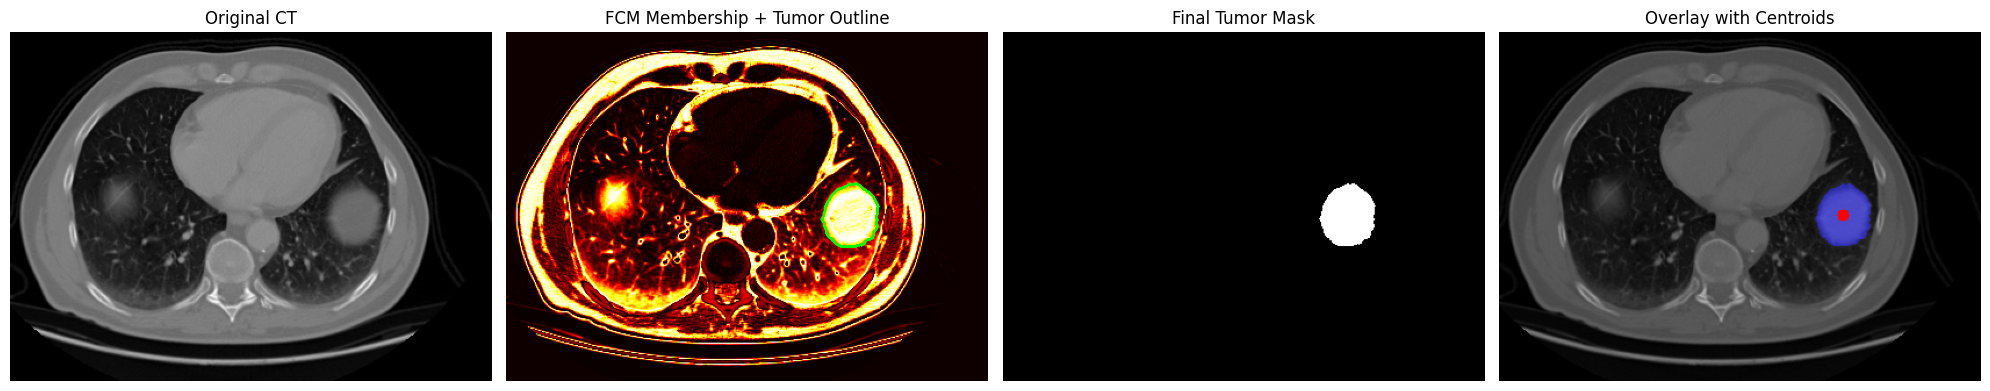

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes, disk, opening
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import skfuzzy as fuzz


class FCM_Combined_Segmenter:
    def __init__(
        self,
        image: np.ndarray,
        num_clusters: int = 3,
        m: float = 2.0,
        max_iter: int = 150,
        threshold: float = 1e-5,
        tumor_cluster: int | None = None,
        confine_to_lungs: bool = True,
        target_lobe: str = "none",      # default none → detect anywhere in lungs
        lobe_margin: float = 0.07,
        brightness_min: float = 0.35,
        min_area: int = 120,
        max_area_frac_of_lung: float = 0.35,
    ) -> None:
        self.image = image
        self.num_clusters = num_clusters
        self.m = m
        self.max_iter = max_iter
        self.threshold = threshold
        self.tumor_cluster = tumor_cluster
        self.confine_to_lungs = confine_to_lungs
        self.target_lobe = target_lobe
        self.lobe_margin = lobe_margin
        self.brightness_min = brightness_min
        self.min_area = min_area
        self.max_area_frac_of_lung = max_area_frac_of_lung

    def _normalize(self):
        img = self.image.astype(np.float32)
        mn, mx = float(img.min()), float(img.max())
        norm = (img - mn) / (mx - mn + 1e-8)
        flat = norm.reshape(-1, 1)
        return norm, flat

    def _lung_mask(self):
        _, thr = cv2.threshold(self.image, 100, 255, cv2.THRESH_BINARY_INV)
        mask = thr > 0
        mask = remove_small_objects(mask, min_size=1500)
        mask = remove_small_holes(mask, area_threshold=2000)
        return mask.astype(np.bool_)

    def _overlay_with_centroids(self, mask, centroids, color_mask=(255, 0, 0), color_dot=(0, 0, 255)):
        ct_rgb = cv2.cvtColor(self.image, cv2.COLOR_GRAY2BGR)

        # paint only accepted blobs
        tumor_layer = np.zeros_like(ct_rgb)
        tumor_layer[mask == 1] = color_mask
        overlay = cv2.addWeighted(ct_rgb, 0.7, tumor_layer, 0.5, 0)

        # add centroid markers
        for (cy, cx) in centroids:
            cv2.circle(overlay, (int(cx), int(cy)), 5, color_dot, -1)

        return overlay

    def _passes_morph_heuristics(self, prop):
        if prop.eccentricity > 0.95:
            return False
        if prop.solidity >= 0.99:
            return False
        return True

    def _passes_lobe_filter(self, centroid):
        if self.target_lobe == "none":
            return True
        h, w = self.image.shape[:2]
        cy, cx = centroid
        x_mid = w * 0.5
        y_mid = h * 0.5
        y_upper = y_mid * (1.0 - self.lobe_margin)
        y_lower = y_mid * (1.0 + self.lobe_margin)
        if self.target_lobe == "left_lower":
            return (cx < x_mid) and (cy > y_lower)
        if self.target_lobe == "left_upper":
            return (cx < x_mid) and (cy < y_upper)
        if self.target_lobe == "right_lower":
            return (cx >= x_mid) and (cy > y_lower)
        if self.target_lobe == "right_upper":
            return (cx >= x_mid) and (cy < y_upper)
        return True

    def segment(self):
        norm, flat = self._normalize()
        cntr, u, *_ = fuzz.cluster.cmeans(flat.T, self.num_clusters, self.m, error=self.threshold, maxiter=self.max_iter)
        lung = self._lung_mask()

        # auto-pick bright cluster inside lungs
        if self.tumor_cluster is None:
            centers = cntr.ravel()
            means_in_lung = [np.mean(u[i].reshape(self.image.shape)[lung]) for i in range(self.num_clusters)]
            scores = [float(centers[i]) * float(means_in_lung[i]) for i in range(self.num_clusters)]
            self.tumor_cluster = int(np.argmax(scores))

        membership_map = u[self.tumor_cluster].reshape(self.image.shape)
        t = threshold_otsu(membership_map)
        binary = (membership_map > t).astype(np.uint8)

        cleaned = remove_small_objects(binary.astype(bool), min_size=150)
        cleaned = remove_small_holes(cleaned, area_threshold=600)
        cleaned = opening(cleaned, disk(3))
        mask = cleaned.astype(np.uint8)

        if self.confine_to_lungs:
            mask = np.logical_and(mask, lung).astype(np.uint8)

        lbl = label(mask)
        out = np.zeros_like(mask)   # only accepted blobs here
        lung_area = int(lung.sum()) if lung.any() else mask.size
        max_area = int(self.max_area_frac_of_lung * lung_area)
        centroids = []

        for prop in regionprops(lbl):
            if not (self.min_area <= prop.area <= max_area):
                continue
            rr, cc = np.where(lbl == prop.label)
            mean_intensity = float(np.mean(norm[rr, cc]))
            if mean_intensity < self.brightness_min:
                continue
            if not self._passes_morph_heuristics(prop):
                continue
            if not self._passes_lobe_filter(prop.centroid):
                continue

            out[lbl == prop.label] = 1
            centroids.append(prop.centroid)

            print(f"Tumor centroid detected at (x={prop.centroid[1]:.1f}, y={prop.centroid[0]:.1f})")

        overlay = self._overlay_with_centroids(out, centroids)
        return self.image, membership_map, out, overlay


if __name__ == "__main__":
    img_path =  r"D:\FYP\DATASET\kagglehub\datasets\mohamedhanyyy\chest-ctscan-images\versions\1\Data\test\adenocarcinoma\000123 (4).png"
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    seg = FCM_Combined_Segmenter(
        img,
        num_clusters=3,
        tumor_cluster=None,
        confine_to_lungs=True,
        target_lobe="none",       # detect anywhere in lungs
        lobe_margin=0.07,
        brightness_min=0.35,
        min_area=120,
        max_area_frac_of_lung=0.35,
    )

    original, membership_map, final_mask, overlay = seg.segment()

    # --- Plotting with tumor outline on heatmap ---
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))
    axs[0].imshow(original, cmap="gray")
    axs[0].set_title("Original CT")

    axs[1].imshow(membership_map, cmap="hot")
    axs[1].contour(final_mask, colors="lime", linewidths=1)   # ✅ outline only accepted tumor
    axs[1].set_title("FCM Membership + Tumor Outline")

    axs[2].imshow(final_mask, cmap="gray")
    axs[2].set_title("Final Tumor Mask")

    axs[3].imshow(overlay[..., ::-1])
    axs[3].set_title("Overlay with Centroids")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# AIM XML

In [19]:
import xml.etree.ElementTree as ET
from xml.dom import minidom
from datetime import datetime
import uuid
import os
import numpy as np
from skimage.measure import label, regionprops


def generate_aim_xml(image_path: str, mask: np.ndarray, centroids: list[tuple], save_path: str = "aim_annotation.xml"):
    filename = os.path.basename(image_path)
    annotation_uid = str(uuid.uuid4())
    now = datetime.utcnow().isoformat()

    NS = {
        'xsi': "http://www.w3.org/2001/XMLSchema-instance",
        'aim': "gme://caCORE.caCORE/4.2/edu.northwestern.radiology.AIM"
    }

    ET.register_namespace('', NS['aim'])
    ET.register_namespace('xsi', NS['xsi'])

    root = ET.Element("ImageAnnotation", {
        "xmlns:xsi": NS['xsi'],
        "xmlns": NS['aim'],
        "xsi:schemaLocation": "gme://caCORE.caCORE/4.2/edu.northwestern.radiology.AIM AIM_v4.2.xsd",
        "uniqueIdentifier": annotation_uid,
        "name": "FCM Tumor Annotation",
        "dateTime": now,
        "codeValue": "R-00317",
        "codeMeaning": "Lesion",
        "codingSchemeDesignator": "99AIM"
    })

    # user
    user = ET.SubElement(root, "user")
    ET.SubElement(user, "name").text = "CodeCopilot"
    ET.SubElement(user, "loginName").text = "codecopilot"
    ET.SubElement(user, "roleInTrial").text = "Segmenter"

    # equipment
    eq = ET.SubElement(root, "equipment")
    ET.SubElement(eq, "manufacturerName").text = "OpenAI"
    ET.SubElement(eq, "modelName").text = "FCM Combined"

    # image reference (simulated)
    img_col = ET.SubElement(root, "imageReferenceCollection")
    img_ref = ET.SubElement(img_col, "ImageReference")
    img_ref.set("xsi:type", "ImageReference")
    ET.SubElement(img_ref, "imageUID").text = annotation_uid
    ET.SubElement(img_ref, "imageFileName").text = filename

    # geometricShapeCollection: centroids
    geo_col = ET.SubElement(root, "geometricShapeCollection")
    for i, (cy, cx) in enumerate(centroids):
        geo = ET.SubElement(geo_col, "GeometricShape", {
            "xsi:type": "Point",
            "shapeIdentifier": str(i + 1),
            "numberOfPoints": "1"
        })
        spatial = ET.SubElement(geo, "spatialCoordinateCollection")
        coord = ET.SubElement(spatial, "SpatialCoordinate", {
            "xsi:type": "TwoDimensionSpatialCoordinate",
            "coordinateIndex": "0",
            "x": f"{cx:.2f}",
            "y": f"{cy:.2f}"
        })

    # polygon for each tumor region
    lbl = label(mask)
    for region in regionprops(lbl):
        coords = list(zip(*np.where(lbl == region.label)))
        geo = ET.SubElement(geo_col, "GeometricShape", {
            "xsi:type": "Polygon",
            "shapeIdentifier": str(region.label),
            "numberOfPoints": str(min(20, len(coords)))
        })
        spatial = ET.SubElement(geo, "spatialCoordinateCollection")
        for j, (y, x) in enumerate(coords[::max(1, len(coords)//20)]):
            ET.SubElement(spatial, "SpatialCoordinate", {
                "xsi:type": "TwoDimensionSpatialCoordinate",
                "coordinateIndex": str(j),
                "x": str(x),
                "y": str(y)
            })

    # calculationCollection
    calc_col = ET.SubElement(root, "calculationCollection")
    for region in regionprops(lbl, intensity_image=mask.astype(float)):
        calc = ET.SubElement(calc_col, "CalculationEntity")
        calc.set("codeValue", "R-00317")
        calc.set("codeMeaning", "TumorMetrics")
        calc.set("codingSchemeDesignator", "99AIM")

        result_area = ET.SubElement(calc, "calculationResultCollection")
        area = ET.SubElement(result_area, "CalculationResult")
        area.set("numberOfDimensions", "2")
        area.set("unitOfMeasure", "pixel")
        area.set("type", "Scalar")

        value = ET.SubElement(area, "value")
        value.text = str(region.area)

    # annotation statement
    ann_stmt = ET.SubElement(root, "annotationStatementCollection")
    stmt = ET.SubElement(ann_stmt, "AnnotationStatement")
    stmt.text = f"Detected {len(centroids)} tumor region(s) from non-DICOM image."

    # pretty print and save
    xmlstr = minidom.parseString(ET.tostring(root)).toprettyxml(indent="  ")
    with open(save_path, "w") as f:
        f.write(xmlstr)

    print(f"✅ AIM 4.0 XML saved to: {save_path}")


# Example usage:
# image, membership_map, final_mask, overlay, centroids = seg.segment()
# generate_aim_xml(img_path, final_mask, centroids)


Tumor centroid detected at (x=83.9, y=143.8)
✅ AIM 4.0 XML saved to: aim_annotation.xml


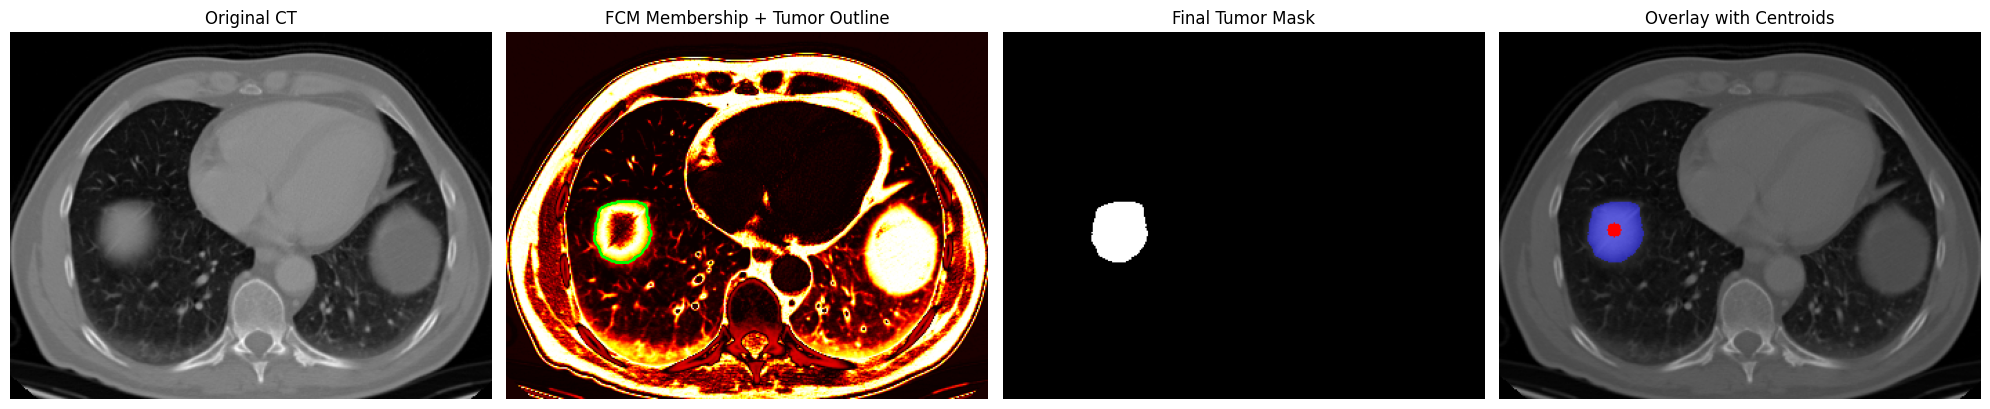

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes, disk, opening
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import skfuzzy as fuzz


class FCM_Combined_Segmenter:
    def __init__(
        self,
        image: np.ndarray,
        num_clusters: int = 3,
        m: float = 2.0,
        max_iter: int = 150,
        threshold: float = 1e-5,
        tumor_cluster: int | None = None,
        confine_to_lungs: bool = True,
        target_lobe: str = "none",      # default none → detect anywhere in lungs
        lobe_margin: float = 0.07,
        brightness_min: float = 0.35,
        min_area: int = 120,
        max_area_frac_of_lung: float = 0.35,
    ) -> None:
        self.image = image
        self.num_clusters = num_clusters
        self.m = m
        self.max_iter = max_iter
        self.threshold = threshold
        self.tumor_cluster = tumor_cluster
        self.confine_to_lungs = confine_to_lungs
        self.target_lobe = target_lobe
        self.lobe_margin = lobe_margin
        self.brightness_min = brightness_min
        self.min_area = min_area
        self.max_area_frac_of_lung = max_area_frac_of_lung

    def _normalize(self):
        img = self.image.astype(np.float32)
        mn, mx = float(img.min()), float(img.max())
        norm = (img - mn) / (mx - mn + 1e-8)
        flat = norm.reshape(-1, 1)
        return norm, flat

    def _lung_mask(self):
        _, thr = cv2.threshold(self.image, 100, 255, cv2.THRESH_BINARY_INV)
        mask = thr > 0
        mask = remove_small_objects(mask, min_size=1500)
        mask = remove_small_holes(mask, area_threshold=2000)
        return mask.astype(np.bool_)

    def _overlay_with_centroids(self, mask, centroids, color_mask=(255, 0, 0), color_dot=(0, 0, 255)):
        ct_rgb = cv2.cvtColor(self.image, cv2.COLOR_GRAY2BGR)

        # paint only accepted blobs
        tumor_layer = np.zeros_like(ct_rgb)
        tumor_layer[mask == 1] = color_mask
        overlay = cv2.addWeighted(ct_rgb, 0.7, tumor_layer, 0.5, 0)

        # add centroid markers
        for (cy, cx) in centroids:
            cv2.circle(overlay, (int(cx), int(cy)), 5, color_dot, -1)

        return overlay

    def _passes_morph_heuristics(self, prop):
        if prop.eccentricity > 0.95:
            return False
        if prop.solidity >= 0.99:
            return False
        return True

    def _passes_lobe_filter(self, centroid):
        if self.target_lobe == "none":
            return True
        h, w = self.image.shape[:2]
        cy, cx = centroid
        x_mid = w * 0.5
        y_mid = h * 0.5
        y_upper = y_mid * (1.0 - self.lobe_margin)
        y_lower = y_mid * (1.0 + self.lobe_margin)
        if self.target_lobe == "left_lower":
            return (cx < x_mid) and (cy > y_lower)
        if self.target_lobe == "left_upper":
            return (cx < x_mid) and (cy < y_upper)
        if self.target_lobe == "right_lower":
            return (cx >= x_mid) and (cy > y_lower)
        if self.target_lobe == "right_upper":
            return (cx >= x_mid) and (cy < y_upper)
        return True

    def segment(self):
        norm, flat = self._normalize()
        cntr, u, *_ = fuzz.cluster.cmeans(flat.T, self.num_clusters, self.m, error=self.threshold, maxiter=self.max_iter)
        lung = self._lung_mask()

        # auto-pick bright cluster inside lungs
        if self.tumor_cluster is None:
            centers = cntr.ravel()
            means_in_lung = [np.mean(u[i].reshape(self.image.shape)[lung]) for i in range(self.num_clusters)]
            scores = [float(centers[i]) * float(means_in_lung[i]) for i in range(self.num_clusters)]
            self.tumor_cluster = int(np.argmax(scores))

        membership_map = u[self.tumor_cluster].reshape(self.image.shape)
        t = threshold_otsu(membership_map)
        binary = (membership_map > t).astype(np.uint8)

        cleaned = remove_small_objects(binary.astype(bool), min_size=150)
        cleaned = remove_small_holes(cleaned, area_threshold=600)
        cleaned = opening(cleaned, disk(3))
        mask = cleaned.astype(np.uint8)

        if self.confine_to_lungs:
            mask = np.logical_and(mask, lung).astype(np.uint8)

        lbl = label(mask)
        out = np.zeros_like(mask)   # only accepted blobs here
        lung_area = int(lung.sum()) if lung.any() else mask.size
        max_area = int(self.max_area_frac_of_lung * lung_area)
        centroids = []

        for prop in regionprops(lbl):
            if not (self.min_area <= prop.area <= max_area):
                continue
            rr, cc = np.where(lbl == prop.label)
            mean_intensity = float(np.mean(norm[rr, cc]))
            if mean_intensity < self.brightness_min:
                continue
            if not self._passes_morph_heuristics(prop):
                continue
            if not self._passes_lobe_filter(prop.centroid):
                continue

            out[lbl == prop.label] = 1
            centroids.append(prop.centroid)

            print(f"Tumor centroid detected at (x={prop.centroid[1]:.1f}, y={prop.centroid[0]:.1f})")

        overlay = self._overlay_with_centroids(out, centroids)
        return self.image, membership_map, out, overlay, centroids



if __name__ == "__main__":
    img_path =  r"D:\FYP\DATASET\kagglehub\datasets\mohamedhanyyy\chest-ctscan-images\versions\1\Data\train\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000083 (3).png"
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    seg = FCM_Combined_Segmenter(
        img,
        num_clusters=3,
        tumor_cluster=None,
        confine_to_lungs=True,
        target_lobe="none",       # detect anywhere in lungs
        lobe_margin=0.07,
        brightness_min=0.35,
        min_area=120,
        max_area_frac_of_lung=0.35,
    )

    original, membership_map, final_mask, overlay, centroids = seg.segment()

    generate_aim_xml(img_path, final_mask, centroids)
    # --- Plotting with tumor outline on heatmap ---
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))
    axs[0].imshow(original, cmap="gray")
    axs[0].set_title("Original CT")

    axs[1].imshow(membership_map, cmap="hot")
    axs[1].contour(final_mask, colors="lime", linewidths=1)   # ✅ outline only accepted tumor
    axs[1].set_title("FCM Membership + Tumor Outline")

    axs[2].imshow(final_mask, cmap="gray")
    axs[2].set_title("Final Tumor Mask")

    axs[3].imshow(overlay[..., ::-1])
    axs[3].set_title("Overlay with Centroids")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# no otsu tresholding

Tumor centroid detected at (x=84.1, y=144.4)


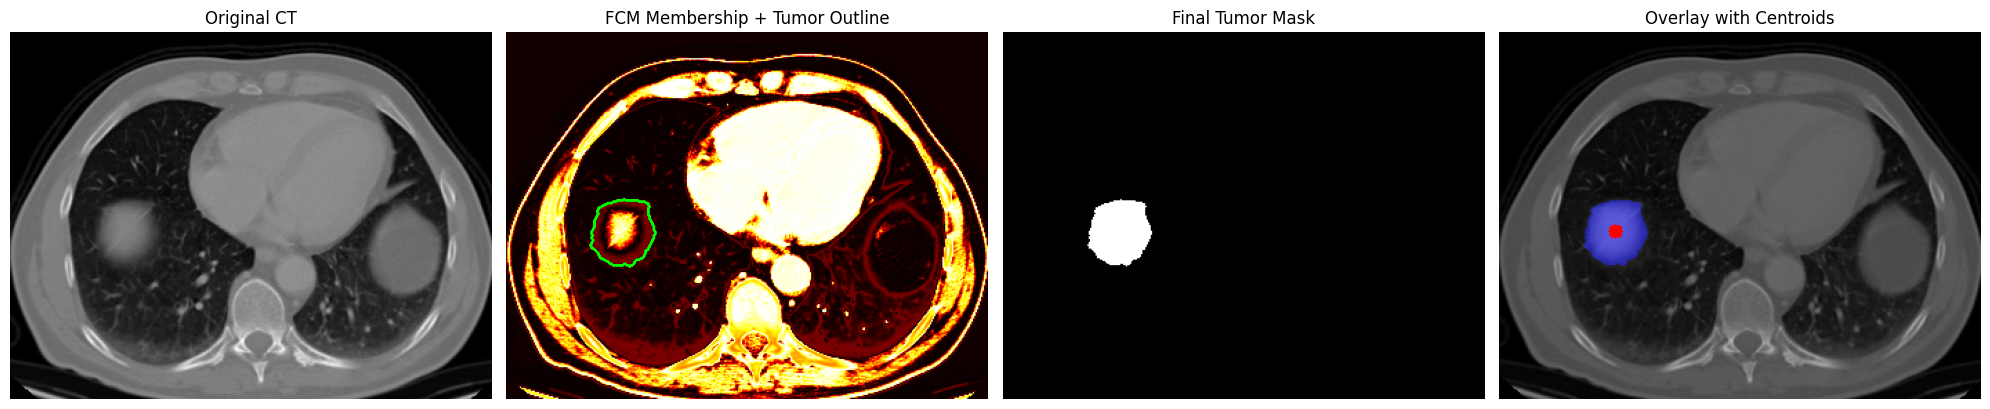

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes, disk, opening
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import skfuzzy as fuzz


class FCM_Combined_Segmenter:
    def __init__(
        self,
        image: np.ndarray,
        num_clusters: int = 3,
        m: float = 2.0,
        max_iter: int = 150,
        threshold: float = 1e-5,
        tumor_cluster: int | None = None,
        confine_to_lungs: bool = True,
        target_lobe: str = "none",
        lobe_margin: float = 0.07,
        brightness_min: float = 0.35,
        min_area: int = 120,
        max_area_frac_of_lung: float = 0.35,
    ) -> None:
        self.image = image
        self.num_clusters = num_clusters
        self.m = m
        self.max_iter = max_iter
        self.threshold = threshold
        self.tumor_cluster = tumor_cluster
        self.confine_to_lungs = confine_to_lungs
        self.target_lobe = target_lobe
        self.lobe_margin = lobe_margin
        self.brightness_min = brightness_min
        self.min_area = min_area
        self.max_area_frac_of_lung = max_area_frac_of_lung

    def _normalize(self):
        img = self.image.astype(np.float32)
        mn, mx = float(img.min()), float(img.max())
        norm = (img - mn) / (mx - mn + 1e-8)
        flat = norm.reshape(-1, 1)
        return norm, flat

    def _lung_mask(self):
        _, thr = cv2.threshold(self.image, 100, 255, cv2.THRESH_BINARY_INV)
        mask = thr > 0
        mask = remove_small_objects(mask, min_size=1500)
        mask = remove_small_holes(mask, area_threshold=2000)
        return mask.astype(np.bool_)

    def _overlay_with_centroids(self, mask, centroids, color_mask=(255, 0, 0), color_dot=(0, 0, 255)):
        ct_rgb = cv2.cvtColor(self.image, cv2.COLOR_GRAY2BGR)
        tumor_layer = np.zeros_like(ct_rgb)
        tumor_layer[mask == 1] = color_mask
        overlay = cv2.addWeighted(ct_rgb, 0.7, tumor_layer, 0.5, 0)
        for (cy, cx) in centroids:
            cv2.circle(overlay, (int(cx), int(cy)), 5, color_dot, -1)
        return overlay

    def _passes_morph_heuristics(self, prop):
        return prop.eccentricity <= 0.95 and prop.solidity < 0.99

    def _passes_lobe_filter(self, centroid):
        if self.target_lobe == "none": return True
        h, w = self.image.shape[:2]
        cy, cx = centroid
        x_mid, y_mid = w * 0.5, h * 0.5
        y_upper, y_lower = y_mid * (1.0 - self.lobe_margin), y_mid * (1.0 + self.lobe_margin)
        if self.target_lobe == "left_lower": return (cx < x_mid) and (cy > y_lower)
        if self.target_lobe == "left_upper": return (cx < x_mid) and (cy < y_upper)
        if self.target_lobe == "right_lower": return (cx >= x_mid) and (cy > y_lower)
        if self.target_lobe == "right_upper": return (cx >= x_mid) and (cy < y_upper)
        return True

    def segment(self):
        np.random.seed(42)  # Fix randomness
        norm, flat = self._normalize()
        cntr, u, *_ = fuzz.cluster.cmeans(flat.T, self.num_clusters, self.m, error=self.threshold, maxiter=self.max_iter)
        lung = self._lung_mask()

        # Fix tumor cluster selection
        if self.tumor_cluster is None:
            self.tumor_cluster = int(np.argmax(cntr.ravel()))  # Always choose brightest cluster

        membership_map = u[self.tumor_cluster].reshape(self.image.shape)
        t = 0.1  # Fixed threshold instead of Otsu
        binary = (membership_map > t).astype(np.uint8)

        cleaned = remove_small_objects(binary.astype(bool), min_size=150)
        cleaned = remove_small_holes(cleaned, area_threshold=600)
        cleaned = opening(cleaned, disk(3))
        mask = cleaned.astype(np.uint8)

        if self.confine_to_lungs:
            mask = np.logical_and(mask, lung).astype(np.uint8)

        lbl = label(mask)
        out = np.zeros_like(mask)
        lung_area = int(lung.sum()) if lung.any() else mask.size
        max_area = int(self.max_area_frac_of_lung * lung_area)
        centroids = []

        for prop in regionprops(lbl):
            if not (self.min_area <= prop.area <= max_area):
                continue
            rr, cc = np.where(lbl == prop.label)
            mean_intensity = float(np.mean(norm[rr, cc]))
            if mean_intensity < self.brightness_min:
                continue
            if not self._passes_morph_heuristics(prop):
                continue
            if not self._passes_lobe_filter(prop.centroid):
                continue
            out[lbl == prop.label] = 1
            centroids.append(prop.centroid)
            print(f"Tumor centroid detected at (x={prop.centroid[1]:.1f}, y={prop.centroid[0]:.1f})")

        overlay = self._overlay_with_centroids(out, centroids)
        return self.image, membership_map, out, overlay, centroids


if __name__ == "__main__":
    img_path = r"D:\FYP\DATASET\kagglehub\datasets\mohamedhanyyy\chest-ctscan-images\versions\1\Data\train\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000083 (3).png"
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    seg = FCM_Combined_Segmenter(img)
    original, membership_map, final_mask, overlay, centroids = seg.segment()

    fig, axs = plt.subplots(1, 4, figsize=(20, 6))
    axs[0].imshow(original, cmap="gray")
    axs[0].set_title("Original CT")

    axs[1].imshow(membership_map, cmap="hot")
    axs[1].contour(final_mask, colors="lime", linewidths=1)
    axs[1].set_title("FCM Membership + Tumor Outline")

    axs[2].imshow(final_mask, cmap="gray")
    axs[2].set_title("Final Tumor Mask")

    axs[3].imshow(overlay[..., ::-1])
    axs[3].set_title("Overlay with Centroids")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


Tumor centroid detected at (x=111.0, y=193.6)


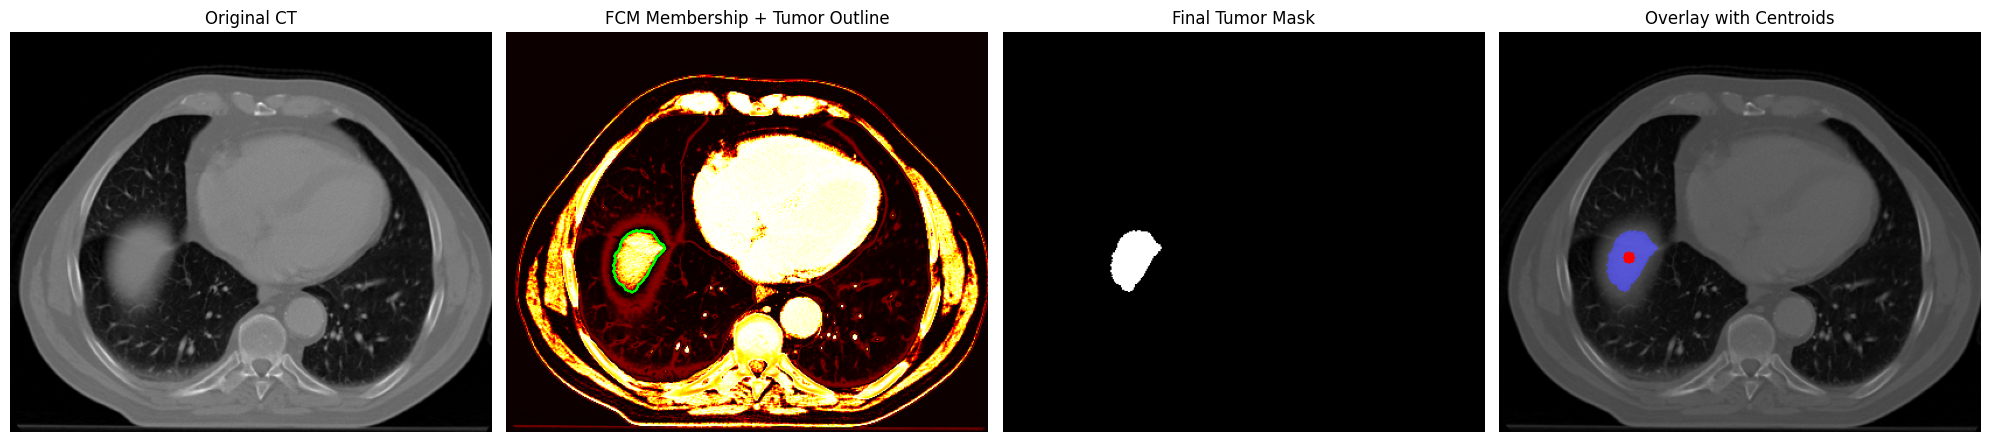

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes, disk, opening
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import skfuzzy as fuzz


class FCM_Combined_Segmenter:
    def __init__(
        self,
        image: np.ndarray,
        num_clusters: int = 3,
        m: float = 2.0,
        max_iter: int = 150,
        threshold: float = 1e-5,
        tumor_cluster: int | None = None,
        confine_to_lungs: bool = True,
        target_lobe: str = "none",
        lobe_margin: float = 0.07,
        brightness_min: float = 0.35,
        min_area: int = 120,
        max_area_frac_of_lung: float = 0.35,
    ) -> None:
        self.image = image
        self.num_clusters = num_clusters
        self.m = m
        self.max_iter = max_iter
        self.threshold = threshold
        self.tumor_cluster = tumor_cluster
        self.confine_to_lungs = confine_to_lungs
        self.target_lobe = target_lobe
        self.lobe_margin = lobe_margin
        self.brightness_min = brightness_min
        self.min_area = min_area
        self.max_area_frac_of_lung = max_area_frac_of_lung

    def _normalize(self):
        img = self.image.astype(np.float32)
        mn, mx = float(img.min()), float(img.max())
        norm = (img - mn) / (mx - mn + 1e-8)
        flat = norm.reshape(-1, 1)
        return norm, flat

    def _lung_mask(self):
        _, thr = cv2.threshold(self.image, 100, 255, cv2.THRESH_BINARY_INV)
        mask = thr > 0
        mask = remove_small_objects(mask, min_size=1500)
        mask = remove_small_holes(mask, area_threshold=2000)
        return mask.astype(np.bool_)

    def _overlay_with_centroids(self, mask, centroids, color_mask=(255, 0, 0), color_dot=(0, 0, 255)):
        ct_rgb = cv2.cvtColor(self.image, cv2.COLOR_GRAY2BGR)
        tumor_layer = np.zeros_like(ct_rgb)
        tumor_layer[mask == 1] = color_mask
        overlay = cv2.addWeighted(ct_rgb, 0.7, tumor_layer, 0.5, 0)
        for (cy, cx) in centroids:
            cv2.circle(overlay, (int(cx), int(cy)), 5, color_dot, -1)
        return overlay

    def _passes_morph_heuristics(self, prop):
        return prop.eccentricity <= 0.95 and prop.solidity < 0.99

    def _passes_lobe_filter(self, centroid):
        if self.target_lobe == "none": return True
        h, w = self.image.shape[:2]
        cy, cx = centroid
        x_mid, y_mid = w * 0.5, h * 0.5
        y_upper, y_lower = y_mid * (1.0 - self.lobe_margin), y_mid * (1.0 + self.lobe_margin)
        if self.target_lobe == "left_lower": return (cx < x_mid) and (cy > y_lower)
        if self.target_lobe == "left_upper": return (cx < x_mid) and (cy < y_upper)
        if self.target_lobe == "right_lower": return (cx >= x_mid) and (cy > y_lower)
        if self.target_lobe == "right_upper": return (cx >= x_mid) and (cy < y_upper)
        return True

    def segment(self):
        np.random.seed(42)  # Fix randomness
        norm, flat = self._normalize()
        cntr, u, *_ = fuzz.cluster.cmeans(flat.T, self.num_clusters, self.m, error=self.threshold, maxiter=self.max_iter)
        lung = self._lung_mask()

        # Fix tumor cluster selection
        if self.tumor_cluster is None:
            self.tumor_cluster = int(np.argmax(cntr.ravel()))  # Always choose brightest cluster

        membership_map = u[self.tumor_cluster].reshape(self.image.shape)
        t = 0.1  # Fixed threshold instead of Otsu
        binary = (membership_map > t).astype(np.uint8)

        cleaned = remove_small_objects(binary.astype(bool), min_size=150)
        cleaned = remove_small_holes(cleaned, area_threshold=600)
        cleaned = opening(cleaned, disk(3))
        mask = cleaned.astype(np.uint8)

        if self.confine_to_lungs:
            mask = np.logical_and(mask, lung).astype(np.uint8)

        lbl = label(mask)
        out = np.zeros_like(mask)
        lung_area = int(lung.sum()) if lung.any() else mask.size
        max_area = int(self.max_area_frac_of_lung * lung_area)
        centroids = []

        for prop in regionprops(lbl):
            if not (self.min_area <= prop.area <= max_area):
                continue
            rr, cc = np.where(lbl == prop.label)
            mean_intensity = float(np.mean(norm[rr, cc]))
            if mean_intensity < self.brightness_min:
                continue
            if not self._passes_morph_heuristics(prop):
                continue
            if not self._passes_lobe_filter(prop.centroid):
                continue
            out[lbl == prop.label] = 1
            centroids.append(prop.centroid)
            print(f"Tumor centroid detected at (x={prop.centroid[1]:.1f}, y={prop.centroid[0]:.1f})")

        overlay = self._overlay_with_centroids(out, centroids)
        return self.image, membership_map, out, overlay


if __name__ == "__main__":
    img_path =     r"D:\FYP\DATASET\kagglehub\datasets\mohamedhanyyy\chest-ctscan-images\versions\1\Data\train\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000084 (7).png"
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    seg = FCM_Combined_Segmenter(img)
    original, membership_map, final_mask, overlay = seg.segment()

    fig, axs = plt.subplots(1, 4, figsize=(20, 6))
    axs[0].imshow(original, cmap="gray")
    axs[0].set_title("Original CT")

    axs[1].imshow(membership_map, cmap="hot")
    axs[1].contour(final_mask, colors="lime", linewidths=1)
    axs[1].set_title("FCM Membership + Tumor Outline")

    axs[2].imshow(final_mask, cmap="gray")
    axs[2].set_title("Final Tumor Mask")

    axs[3].imshow(overlay[..., ::-1])
    axs[3].set_title("Overlay with Centroids")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()
